In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')

In [4]:
df['QTY'] = df['QTY'].astype(str)
outtakes = df[df.QTY.str.contains('[a-zA-Z]|\.\d\d$|\.\d\d\d\d$')]
df = df.drop(outtakes.index)
df['QTY'] = df['QTY'].apply(lambda x: re.sub('\.','',re.sub('\..$','',x))).astype(float)
df = df.drop([key for key in list(df.keys()) if df[key].sum()==0], axis=1)

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

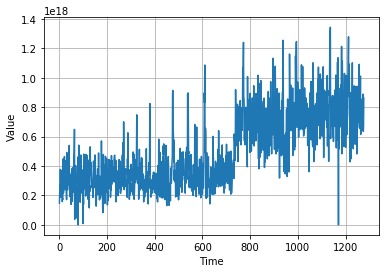

In [6]:
ts = df.groupby(['DATE_ID'])['QTY'].sum().reset_index(name='sum(QTY)')
time = ts.DATE_ID.values
series = ts['sum(QTY)'].values
plot_series(time,series)

In [7]:
split_time = 365*2
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [13]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

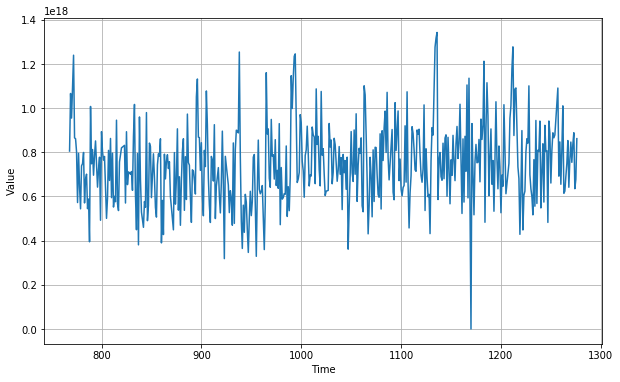

In [14]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
history = model.fit(dataset,epochs=100,verbose=0)

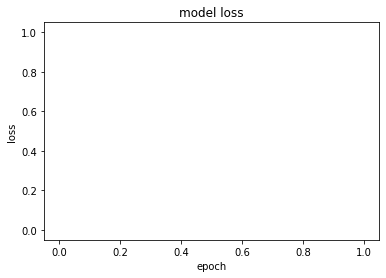

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
#get mean and std for scaling
std_scale = StandardScaler().fit(series)
#apply scaling
series_scaled = std_scale.transform(series)

ValueError: Expected 2D array, got 1D array instead:
array=[1.4791120e+17 2.7381185e+17 2.3158055e+17 ... 6.3514150e+17 6.7775850e+17
 8.6181625e+17].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [21]:
series_reshaped = series.reshape(-1,1)

In [23]:
std_scale = StandardScaler().fit(series_reshaped)
series_scaled = std_scale.transform(series_reshaped)

In [24]:
series_scaled.shape

(1219, 1)

In [28]:
#does the code still work this way?
time = ts.DATE_ID.values
split_time = 365*2
time_train = time[:split_time]
x_train = series_scaled[:split_time]
time_valid = time[split_time:]
x_valid = series_scaled[split_time:]

array([1.000e+00, 3.000e+00, 4.000e+00, ..., 1.274e+03, 1.275e+03,
       1.276e+03])